<a href="https://colab.research.google.com/github/amir9ume/practice_work/blob/master/EM_algorithm_Mixture_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6269 - Homework 3 - EM and Gaussian mixtures
**Due:**  Tuesday, November 5, 2019

#### Name: Amir Raza
#### Student ID: 20139365
#### Collaborators: Mostafa Al Araby, Jose Francisco Gallegos, Albert



## Introduction

The file `EMGaussian.train` contains samples of data $\{x_n\}_{n=1}^N$ where $x_n \in \mathbb{R}^2$, with one datapoint per row. The goal of this exercise is to implement the K-Means and EM algorithms using $K=4$ components/clusters. 

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...",
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw3_thomasBayes.ipynb`
2.   Read the instructions provided on each section and cell carefully,
4.   Implement the requested algorithms in section **Playground**
5.   In section **Model Comparison**, simply execute the cells (without changing the code) and type your answers to the questions in the provided text cells.
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

In [ ]:
!wget http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A19/notes/hwk3data.zip
!unzip hwk3data.zip

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

X_train = np.loadtxt("/content/hwk3data/EMGaussian.train")
X_test = np.loadtxt("/content/hwk3data/EMGaussian.test")

--2019-11-08 04:36:06--  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A19/notes/hwk3data.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7269 (7.1K) [application/zip]
Saving to: ‘hwk3data.zip.2’

hwk3data.zip.2      100%[===================>]   7.10K  --.-KB/s    in 0s      

2019-11-08 04:36:06 (526 MB/s) - ‘hwk3data.zip.2’ saved [7269/7269]

Archive:  hwk3data.zip
replace hwk3data/EMGaussian.test? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hwk3data/EMGaussian.train? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions!

In [ ]:

# ---------------------------------------------------------------------------
#                       Code for plotting the results 
#                      ! DO NOT MODIFY THESE FUNCTIONS !
# ---------------------------------------------------------------------------

from matplotlib.patches import Ellipse
def plot_ellipse(ax, mu, sigma, alpha=1, color="k"):
    evals, evecs = np.linalg.eigh(sigma)
    x, y = evecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))
    for factor in [1.5, 3]:
        w, h = factor * np.sqrt(evals)
        ellipse = Ellipse(mu, w, h, theta, facecolor='none', edgecolor=color) 
        ellipse.set_alpha(alpha)
        ax.add_artist(ellipse) 
        
def show_kmeans(X_train, X_test, KM_centroids, KM_predictor):
    
    shapes = ['o', '*', 'v', '+']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b',
              '#e377c2', '#7f7f7f', '#bcbd22']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, obj = KM_predictor(data)
        print("K-Means Objective on " + title + ": ", obj)
        cs = [colors[int(_) % len(colors)] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=cs)
        ax.scatter(KM_centroids[:, 0], KM_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')    
        
    plt.show()
    print('\n')
    
    
def show_mog(X_train, X_test, MoG_pi, MoG_centroids, MoG_sigmas, MoG_predictor):
    
    shapes = ['o', '*', 'v', '+']  
    colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [148, 103, 189],
             [140, 86, 75], [227, 119, 194], [127, 127, 127], [188, 189, 34]]
    
    max_pi = np.max(MoG_pi)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, norm_llike = MoG_predictor(data)
        print("MoG Normalized Log-Likelihood " + title + ": ", norm_llike)
        cs = [colors[int(_) % len(colors)] + [0.5*255*MoG_pi[_]/max_pi] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], c=np.array(cs)/255.)
        ax.scatter(MoG_centroids[:, 0], MoG_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')    
        
        for _ in range(MoG_pi.shape[0]):
            plot_ellipse(ax, MoG_centroids[_, :], MoG_sigmas[_, :,:], alpha=MoG_pi[_]/max_pi, color='k')
    
    plt.show()
    print('\n')

In [ ]:

#reference taken from this code available here https://flothesof.github.io/k-means-numpy.html
from scipy.stats import multivariate_normal

def closest_centroid(points, centroids):
     #calculating distances of the points from centroids
    squared_points= (points - centroids[:, np.newaxis])**2
    euclidean_distances = np.sqrt((squared_points).sum(axis=2))
    norm_dis= (squared_points).sum(axis=2)
    #return the closest cluster for each of those points
    return np.argmin(euclidean_distances, axis=0), euclidean_distances,norm_dis

def distance_from_closest_centroid(closest, distances):
    # Loss is defined for calculating the distances 
    #from the assigned clusters for each of the points
    loss=0
    for i in range(distances.shape[1]):
      loss+=distances[closest[i],i]
      
    return loss


def update_centroid(points, closest, centroids):
    #get new centroids based on the ones with closest distance 
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

#why is K=1 set here?
def KMeans(X, K=1):
    """
    Estimates the parameters of a K-means model using training data X
        
        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of clusters to use
            
        Returns:
            centroids: [Kx2] matrix of estimated centroid locations
            KMeans_predictor: function taking a matrix inX and returning the
                 predicted cluster number (starting from 0 to K-1) for each row 
                 of inX; and the normalized log-likelihood (i.e., divided by the
                 number of rows of inX).
                 
    """
    
    #data is 2 dimensional
    # TODO
    centroids = np.random.randn(K, 2)

    #to begin with random initialisation, then iteratively improving it
    iteration=0
    #initializing the delta variable which holds the differenced norm between new and old centroid
    delta=10
    #defining delta as the norm of the difference between the new and old centroids  
    #running the iterations till there is no more movement of the centroids
    while(delta>0.001):
      print('iteration number ', iteration)
      closest, distance, n_dis= closest_centroid(X, centroids)  
      
      centroids_new= update_centroid(X, closest, centroids )      
      delta= np.linalg.norm(centroids- centroids_new)
      centroids=centroids_new.copy()
      print('Delta is ', delta)      
      print('------<>---------')
      iteration+=1

    def KMeans_predictor(inX):
        """
        # TODO: use parameters from above to predict cluster for each row of inX
        
            Inputs:
                inX: [mx2] matrix of inputs
                
            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loglike: K-Means loss on inX, divided by the number of rows of inX
        """
         
       # pred_labels = np.random.randint(0, K, inX.shape[0]) #This must be a vector of integers
        #distances are the square root of the sum of squared euclidean distances
        #pred_labels are the assigned clusters for each of the data points
        pred_labels, distances,norm_dis= closest_centroid(inX, centroids)

        #calculating distances of points from their assigned clusters
        norm_loss= distance_from_closest_centroid(pred_labels,norm_dis)/inX.shape[0] 
        return pred_labels, norm_loss
    
    return centroids, KMeans_predictor


def inference_step(X, clusters):
    denominator = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    #working on each of the clusters individually
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        covariance_k = cluster['covariance_k']
        gamma_z_ik = (pi_k * multivariate_normal.pdf(X, mu_k, covariance_k,allow_singular=True)).astype(np.float64)
        
        for i in range(X.shape[0]):             
            denominator[i] += gamma_z_ik[i]
        
        gamma_z_ik= gamma_z_ik.reshape(-1,1)
        
        cluster['gamma_z_ik'] = gamma_z_ik
        cluster['denominator'] = denominator
    
    
    for cluster in clusters:
        cluster['gamma_z_ik'] /= cluster['denominator']

   # sigmas = np.concatenate([sigmak2[_] * np.eye(2)[np.newaxis, ...] for _ in range(K)], axis=0) 
    probs=np.concatenate( [ clusters[i]['gamma_z_ik'] for i in range(len(clusters))] , axis=1)
    
    p= np.argmax(probs,axis=1) 
    
    return p

def expectation_step(X, clusters):
    denominator = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    #working on each of the clusters individually
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
       # covariance_k = cluster['covariance_k'].reshape(-1,2)
        covariance_k = cluster['covariance_k']
       
         
        gamma_z_ik = (pi_k * multivariate_normal.pdf(X, mu_k, covariance_k, allow_singular=True)).astype(np.float64)
        
        
        #for each of the data points, assuming a particular cluster k
        for i in range(X.shape[0]):             
            denominator[i] += gamma_z_ik[i]
        #print('shape of denominator ', denominator.shape)
        gamma_z_ik= gamma_z_ik.reshape(-1,1)
       # print('shape of gamma nk ', gamma_z_ik.shape)
        
        cluster['gamma_z_ik'] = gamma_z_ik
        cluster['denominator'] = denominator
        
    
    for cluster in clusters:
        cluster['gamma_z_ik'] /= cluster['denominator']

def maximization_step(X, clusters,use_full_cov):
    N = float(X.shape[0])
    eps= 0.00001    
    for cluster in clusters:
        gamma_z_ik = cluster['gamma_z_ik']
        #initialising shape according to number of dimensions
        covariance_k = np.zeros((X.shape[1], X.shape[1]))
        
        #Z_nk is number of elements in that class
        Z_nk = np.sum(gamma_z_ik, axis=0) 
        pi_k = Z_nk / N
        mu_k = np.sum(gamma_z_ik * X, axis=0) / Z_nk

        if use_full_cov==True: 
          for j in range(X.shape[0]):
              diff = (X[j] - mu_k).reshape(-1, 1)
              covariance_k += gamma_z_ik[j] * np.dot(diff, diff.T)
            

          covariance_k /= Z_nk
        if use_full_cov==False:
            denom=2* Z_nk
            sigma_k = np.sum([gamma_z_ik[i] * np.linalg.norm(X[i] - mu_k)**2 for i in range(X.shape[0])]) / denom
            sigma_k = sigma_k[0]*np.eye(2)
            covariance_k= sigma_k +eps

        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['covariance_k'] = covariance_k#.reshape(-1,2)
        #cluster['covariance_k'] = covariance_k

def calculate_data_likelihood(X, clusters):
    likelihood = []
    observation_likelihood = np.log(np.array([cluster['denominator'] for cluster in clusters]))
    data_likelihood= np.sum(observation_likelihood)
    return data_likelihood


def train_gmm(X, n_clusters, max_iterations, clusters ,use_full_cov):
    #clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((max_iterations, ))
    
    for i in range(max_iterations):
      
        expectation_step(X, clusters)
        maximization_step(X, clusters,use_full_cov)

        likelihood = calculate_data_likelihood(X, clusters)
        likelihoods[i] = likelihood
        print('Iteration: ', i + 1, 'Likelihood: ', likelihood)

    return clusters, likelihoods

# def covariance_initialize_kmeans(X,pred_labels,K):
#   print('data ', X[pred_labels[K])
#   sig= np.cov(X[pred_labels[K]][0],X[pred_labels[K]][1])
#   print('sig init ', sig)
#   return sig
#   #print('init sig shape ', sig.shape)



#reference for this code taken from https://github.com/ocontreras309/ML_Notebooks/blob/master/GMM_Implementation.ipynb

def GaussianMixture(X, K=1, use_full_cov=True):
    """
    Estimates the parameters of a Gaussian mixture model using training data X
    
    **Important:** The locations of the centroids must be initialized using your 
    K-Means code! With this information, initialize the proportions and variances
    accordingly.
    
        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of mixture components to use
            use_full_cov: [bool] if True, estimate a full covariance for each 
                mixture component. Else, we use a scaled identity for each 
                component (in this case each component might have a 
                different scaling of the identity: Sigma_i = sigma_i * I).
            
        Returns:
            pi: [K] vector of proportion of each class
            centroids: [Kx2] matrix of estimated centroid locations
            sigmas: [Kx2x2] tensor of estimated covariance matrices
            MoG_predictor: function taking a matrix inX and returning the
                 predicted cluster number (starting from 0 to K-1) for each row 
                 of inX; and the normalized log-likelihood (i.e., divided by the
                 number of rows of inX).
    """
    
    # Initialize centroids using KMeans
    centroids, km_predictor = KMeans(X, K)
    mu_k = centroids
    pred_labels_kmeans,_= km_predictor(X)

    pi=np.zeros(K)
    for k in range(K):
        count=list(pred_labels_kmeans).count(k)
        pi[k]=count/X.shape[0]

    


    
    # TODO
    
    # This is just boiler-plate code. Change this to do the right computations
    # but **keep the same names and shape for these variables** 
    #pi = np.ones(K)/K
        
     # TODO
    
    if use_full_cov:
        # We use a full covariance for each class
        #pass the exact same values which you have prepared for the clusters
        sigmas = np.concatenate(K*[np.eye(2)[np.newaxis, ...]], axis=0)
        shape_required_sigmas=sigmas.shape
        
    else:
        # We use one scaled identity for each class
        #get these values instead of passing ones
        sigmak2 = np.ones(K) # These are the sigma^2_k for k=1, ..., K
      
        sigmas = np.concatenate([sigmak2[_] * np.eye(2)[np.newaxis, ...] for _ in range(K)], axis=0)
        # Careful! We expect to return the covariance matrix. Don't mix these up!
        shape_required_sigmas=sigmas.shape
    
    clusters=[]
            
    for i in range(K):
        clusters.append({
            'pi_k': pi[i],
            'mu_k': mu_k[i],
            
            'covariance_k': sigmas[i]
        })
  
    
      
    clusters_learned, likelihoods= train_gmm(X, K, 50, clusters , use_full_cov )
    
    centroids_final=[]
    sigmas_final=[]
    pi_final=[]

    for cluster_l in clusters_learned:
      
      centroids_final.append(cluster_l['mu_k'].reshape(2,-1))
      sigmas_final.append(cluster_l['covariance_k'])
      pi_final.append(cluster_l['pi_k'])

    centroids_final=np.asarray(centroids_final)
    
    
    sigmas_final= np.asarray(sigmas_final)
   # print('shape of covar final ', sigmas_final.shape)
    pi_final=np.asarray(pi_final).reshape(-1)
   # print('shape of pi final ', pi_final.shape)

   # print('shape centroids final ', centroids_final.shape)
    def MoG_predictor(inX):
        """
        # TODO: use parameters from above to predict cluster for each row of inX
        
            Inputs:
                inX: [mx2] matrix of inputs
                
            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loglike: (lower bound on) the log-likelihood for inX  divided
                    by the number of rows of inX
        """
        print('------<Inference step>---------')
        print('use of full covariance ', use_full_cov)
        pred_labels= inference_step(inX,clusters_learned)
        
        likelihood = calculate_data_likelihood(inX, clusters_learned)
        
        norm_loglike = likelihood/inX.shape[0]
        
        return pred_labels, norm_loglike

    print('sum of pi', pi.sum())
    return pi_final, centroids_final, sigmas_final, MoG_predictor       
    
   # return pi, centroids, sigmas, MoG_predictor    

## Model Comparison

In this section **DO NOT** change the code in any of the cells. Simply answer the questions in the corresponding text cells after having executed your implementation. If you have respected the signature of the functions above in terms of inputs and outputs, your code should run. 

### K-Means


iteration number  0
Delta is  6.714761271534158
------<>---------
iteration number  1
Delta is  0.818054548941368
------<>---------
iteration number  2
Delta is  0.8046787066991936
------<>---------
iteration number  3
Delta is  1.1970936348325105
------<>---------
iteration number  4
Delta is  1.0388158596406007
------<>---------
iteration number  5
Delta is  0.49918244760084474
------<>---------
iteration number  6
Delta is  0.42933101740345375
------<>---------
iteration number  7
Delta is  0.373145341189649
------<>---------
iteration number  8
Delta is  0.5181604450157197
------<>---------
iteration number  9
Delta is  1.2203362071907573
------<>---------
iteration number  10
Delta is  1.495136539050444
------<>---------
iteration number  11
Delta is  0.6197314413320669
------<>---------
iteration number  12
Delta is  0.1275931087561505
------<>---------
iteration number  13
Delta is  0.14028772742977402
------<>---------
iteration number  14
Delta is  0.08996673254042488
------<>

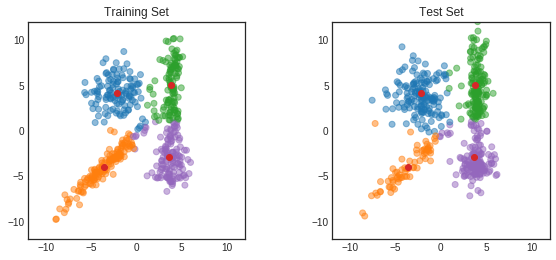



iteration number  0
Delta is  6.28970217719568
------<>---------
iteration number  1
Delta is  1.919745400689875
------<>---------
iteration number  2
Delta is  1.8456545171835457
------<>---------
iteration number  3
Delta is  1.248035610112671
------<>---------
iteration number  4
Delta is  0.63647625197888
------<>---------
iteration number  5
Delta is  0.3781247568180387
------<>---------
iteration number  6
Delta is  0.4493113818499555
------<>---------
iteration number  7
Delta is  0.6128941790831113
------<>---------
iteration number  8
Delta is  0.5584445693335901
------<>---------
iteration number  9
Delta is  0.5848482308764136
------<>---------
iteration number  10
Delta is  1.2380808539310233
------<>---------
iteration number  11
Delta is  1.495136539050444
------<>---------
iteration number  12
Delta is  0.619731441332067
------<>---------
iteration number  13
Delta is  0.1275931087561505
------<>---------
iteration number  14
Delta is  0.14028772742977402
------<>-----

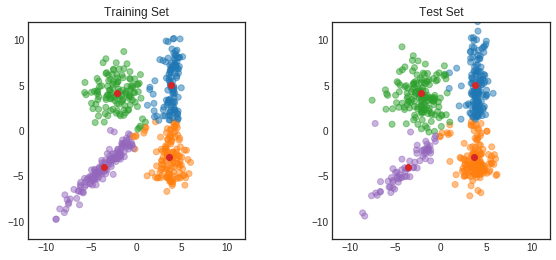



iteration number  0
Delta is  9.501337313281882
------<>---------
iteration number  1
Delta is  0.22845858262642846
------<>---------
iteration number  2
Delta is  0.06276914910658117
------<>---------
iteration number  3
Delta is  0.0
------<>---------
K-Means Objective on Training Set:  6.478480915746536
K-Means Objective on Test Set:  6.225629181479415


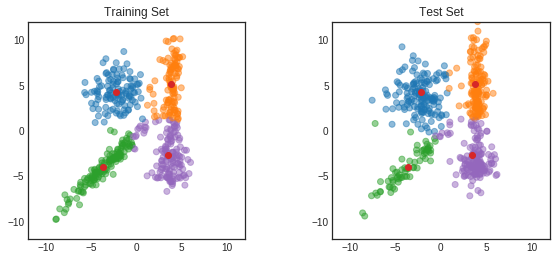

In [ ]:

for run in range(3):
    KM_centroids, KM_predictor = KMeans(X_train, K=4)
    show_kmeans(X_train, X_test, KM_centroids, KM_predictor)

We have trained your implementation of the K-Means algorithm using `X_train` for 3 different initializations. 

**Question:** Briefly compare the results above in terms of the location of the centers and the K-means training objective (at convergence) across runs with different initializations. What conclusions can you draw from this? 

**Answer:** I observed that since there were three iterations,with different intialisations, we took different number of iterations to reach to convergence. Second run took the larget number of runs, and if we actually look at the distance between the initial point and final convergence it was largest distance also (value= ). Hence intiialisation matters for K-Means

### EM for Gaussian mixture models 

Scaled identity covariance matrices
iteration number  0
Delta is  6.999723727013384
------<>---------
iteration number  1
Delta is  1.3462908768860917
------<>---------
iteration number  2
Delta is  0.9841661724868278
------<>---------
iteration number  3
Delta is  1.1433629089712836
------<>---------
iteration number  4
Delta is  1.1306831586082537
------<>---------
iteration number  5
Delta is  1.0324863693269968
------<>---------
iteration number  6
Delta is  0.8362142777301494
------<>---------
iteration number  7
Delta is  0.42784754775947187
------<>---------
iteration number  8
Delta is  0.041815042792038806
------<>---------
iteration number  9
Delta is  0.0
------<>---------
Iteration:  1 Likelihood:  -12879.432652327909
Iteration:  2 Likelihood:  -10628.926403571773
Iteration:  3 Likelihood:  -10618.484237754172
Iteration:  4 Likelihood:  -10615.460344787767
Iteration:  5 Likelihood:  -10613.978811696588
Iteration:  6 Likelihood:  -10613.275457262644
Iteration:  7 Likelihood:

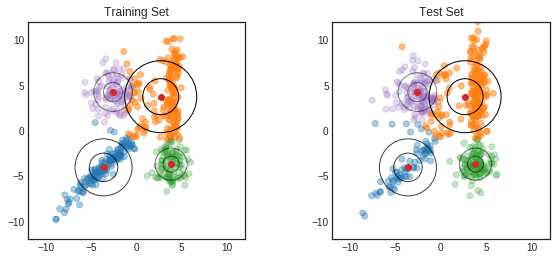




Full covariance matrices
iteration number  0
Delta is  6.58525574993581
------<>---------
iteration number  1
Delta is  2.0551851863861446
------<>---------
iteration number  2
Delta is  2.456056507845592
------<>---------
iteration number  3
Delta is  1.7416906081742949
------<>---------
iteration number  4
Delta is  1.420357835879076
------<>---------
iteration number  5
Delta is  0.8281177730032387
------<>---------
iteration number  6
Delta is  0.18449038343782956
------<>---------
iteration number  7
Delta is  0.19121142785281903
------<>---------
iteration number  8
Delta is  0.15996503927630112
------<>---------
iteration number  9
Delta is  0.04606537417715576
------<>---------
iteration number  10
Delta is  0.0
------<>---------
Iteration:  1 Likelihood:  -12872.56480260043
Iteration:  2 Likelihood:  -9580.942158673077
Iteration:  3 Likelihood:  -9429.828993304473
Iteration:  4 Likelihood:  -9358.302192814808
Iteration:  5 Likelihood:  -9338.381672091036
Iteration:  6 Likel

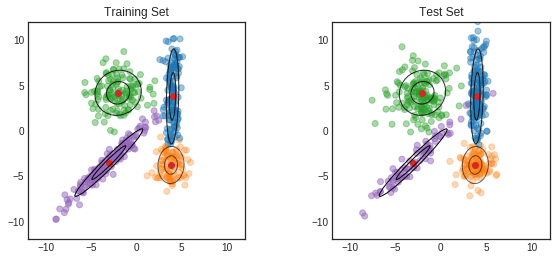

In [ ]:
print('Scaled identity covariance matrices')
MoG1 = GaussianMixture(X_train, K=4, use_full_cov=False)
show_mog(X_train, X_test, MoG1[0], MoG1[1], MoG1[2], MoG1[3])

print('\nFull covariance matrices')
MoG2 = GaussianMixture(X_train, K=4, use_full_cov=True)
show_mog(X_train, X_test, MoG2[0], MoG2[1], MoG2[2], MoG2[3])

We have trained your implementation of the EM algorithm for a Gaussian mixture model using `X_train`. The plots show the behavior on the training and testing (left and right) sets when using scaled diagonal or full covariance matrices (top and bottom), respectively. 

**Question:** Briefly compare the results above in terms of the location of the centers and the normalized log-likelihood between the training and test set. What conclusions can you draw from this? 

**Answer:** Full covariance was able to fit data better and gave ellipses which can adjust to the spread of data well. Scaled diagonal approach had lesser flexibility and it gave circles which did not fit the data spread well. This scaled/spherical covarinace is a very strong restriction.

### Bonus
**Question:** From your observations on the K-Means and EM sections, is there any relation one can stablish between these two methods? f so, how do the plots above reflect this?  

**Answer:** If we look at the plot of the scaled identity covariance(spherical covariances), we can see that it is kind of similar to the K-means plots which are also based on euclidean distances(euclidean distance measures always show up as circles in plots ). EM is basically a soft assignment approach, compared to K-means which does a hard assignment. So if all initial cluster probabilities are set to 1/no. of clusters and \sigma^2 values are taken to 0, we will get the same result for EM as we got for K-means